In [39]:
from torchaudio import transforms as T
from torchaudio import functional as F
import torchaudio
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [23]:
import subprocess
from pathlib import Path
import os

for file in os.listdir("Data"):
    if not file.endswith(".wav"):
        print(file)
        file_input = os.path.join("Data",file)
        file_output = os.path.join("Data", f"converted_{Path(file).suffix[1:]}_{Path(file).stem}.wav")
        subprocess.run(["ffmpeg", "-i", file_input, file_output])

data.rar
tester.m4a
tester.mp3


In [6]:
# class MyModule(torch.nn.Module):
#     pass

torch.Size([2, 201, 32129])


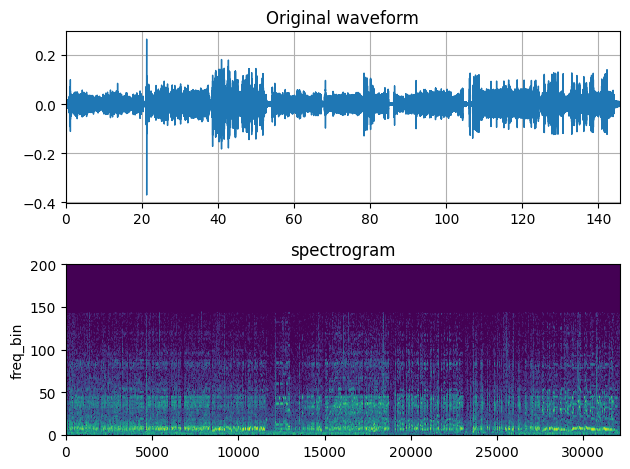

In [40]:
waveform, sr = torchaudio.load("Data/converted_m4a_tester.wav") # this returns a tuple of the waveform and the sample rate

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    from librosa import power_to_db
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


spec = T.Spectrogram()(waveform)
print(spec.shape)

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sr, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()